# Introduction


The dataset contains informations about sessions as follow:
- row_num: a number uniquely identifying each row.
- locale: the platform of the session.
- day_of_week: Mon-Fri, the day of the week of the session.
- hour_of_day: 00-23, the hour of the day of the session.
- agent_id: the device used for the session.
- entry_page: describes the landing page of the session.
- path_id_set: shows all the locations that were visited during the session.
- traffic_type: indicates the channel the user cane through eg. search engine, email, ...
- session_duration: the duration in seconds of the session.
- hits: the number of interactions with the trivago page during the session.
 
The steps that I will go through are:
- Data preparation: selection, preprocessing and transformation.
- Spot check algorithms: trying different prediction algorithms: Linear regression, Decision trees for regression, SVM for regression.
- Improve results: try to improve the best performing algorithms.
- Present results - conclusion.

# Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Prepare Data

As a first step, we need to understand our data and know what data is available, is there missing values? What is the type of the attributes? etc.

## Step 1: Load Data

In [2]:
#read the data using pandas
records = pd.read_csv("ML_Data_Scientist_Case_Study_Data/ML Data Scientist Case Study Data.csv",delimiter=';')

In [3]:
#check the head of the data to get an overview of its columns
records.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


In [4]:
records.columns = ["row_num","locale","day_of_week","hour_of_day","agent_id","entry_page","path_id_set","traffic_type","session_duration","hits"]

In [5]:
records.tail()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_duration,hits
988676,5,L2,Tuesday,18,2,2113,44232;0,2,5,\N
988677,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,\N
988678,3,L2,Sunday,17,8,2114,15466;0,6,1011,\N
988679,2,L3,Monday,17,13,2113,531228;0,2,132,\N
988680,1,L4,Thursday,15,1,2116,76673;0,2,4544,18


It's important to get an idea about the shape of our dataset which help us better chose later what transformations are needed.

In [6]:
records.shape

(988681, 10)

We have a big dataset, but what about the type of the columns? This information is needed for preparation of the data as input to the models because some algorithms have restrictions on the type.

In [7]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
row_num             988681 non-null int64
locale              988681 non-null object
day_of_week         988681 non-null object
hour_of_day         988681 non-null int64
agent_id            988681 non-null int64
entry_page          988681 non-null int64
path_id_set         983792 non-null object
traffic_type        988681 non-null int64
session_duration    988681 non-null object
hits                988681 non-null object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


Some of the columns are of type objects like day_of_week and hour_of_day and session_duration. We will invesigate more on these types later.

Also, we can notice that **only** the column **path_id_set** contains missing values. We can confirm that by using isnull() method.

In [8]:
#check null values
records.isnull().sum()

row_num                0
locale                 0
day_of_week            0
hour_of_day            0
agent_id               0
entry_page             0
path_id_set         4889
traffic_type           0
session_duration       0
hits                   0
dtype: int64

But by looking at our dataset head/tail, there are some rows where  the attribute **hits** is assigned '\N' value. I expect that this value means missing value since we already know that there is missing values for that column and we didn't get that using the null() function because it only considers NaN numpy values.

In [9]:
#check hits not available values
records[records['hits']=='\\N'].head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_duration,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
15,988666,L3,Thursday,16,10,2700,0;34387;84765,1,5189,\N
16,988665,L4,Sunday,16,10,2113,79148;0,4,5,\N
17,988664,L3,Tuesday,19,6,2100,0;34602;34604,1,8041,\N
18,988663,L3,Friday,20,10,2111,34287;0;60579,2,117,\N


Let's see what the describe() method tells us about the distribution of numerical values before deepening using visualizations.

In [10]:
#get an idea about statistic description of numeric values
records.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type
count,988681.000000,988681.000000,988681.000000,988681.000000,988681.000000
mean,494341.000000,13.203988,7.350779,2253.265114,2.773766
std,285407.765082,6.718056,3.869630,775.083390,1.920976
min,1.000000,0.000000,0.000000,2100.000000,1.000000
25%,247171.000000,8.000000,6.000000,2111.000000,1.000000
50%,494341.000000,14.000000,9.000000,2113.000000,2.000000
75%,741511.000000,19.000000,10.000000,2116.000000,4.000000
max,988681.000000,23.000000,15.000000,8101.000000,10.000000


As our goal is to predict the hits for all the rows where hits is not available, we need to know how many rows are they?

In [4]:
#create a dataframe filtered by non available hits
hits_null = records[records['hits']=='\\N']
#get the number of rows having unavailable hits
len(hits_null)

369446

It seems to be a large amount of unavailable hits in our dataset. To get a better estimation, we can calculate the percentage.

In [5]:
round(len(hits_null) *100 / len(records),2)

37.37

So we have 37% of our dataset with missing values of hits, or values to predict. From that we can also conclude that we are going to use only around 60% of our data in the training phase of the model.

## Step 2: Data Selection

In this step, I will explore the relations between different features and try to discover the important ones before applying any method that automatically does that. I will start by some visualizations.

Let's see the distribution of our variables.

In [6]:
#check the type of hits as we found that it's an object type.
type(records['hits'])

pandas.core.series.Series

As we need to know the relation of hits with the other features, we need to change the type of hits. We will consider only the rows where hits are known because those are the rows that will be used in our prediction model.

In [7]:
records_hits_available = records[records['hits'] != '\\N']
records_hits_available.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
5,988676,L3,Monday,1,8,2100,0,1,0,2


Now we can convert the type of hits to int.

In [8]:
#change hits type to int
records_hits_available['hits'] = records_hits_available.hits.astype(int)
#verify the change made for hits type
records_hits_available.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619235 entries, 1 to 988680
Data columns (total 10 columns):
row_num              619235 non-null int64
locale               619235 non-null object
day_of_week          619235 non-null object
hour_of_day          619235 non-null int64
agent_id             619235 non-null int64
entry_page           619235 non-null int64
path_id_set          616082 non-null object
traffic_type         619235 non-null int64
session_durantion    619235 non-null object
hits                 619235 non-null int64
dtypes: int64(6), object(4)
memory usage: 52.0+ MB


In [9]:
#check statistical description of hits variable
records_hits_available['hits'].describe()

count    619235.000000
mean         18.210079
std          39.099699
min           1.000000
25%           3.000000
50%           7.000000
75%          19.000000
max        4174.000000
Name: hits, dtype: float64

There is a big difference between the max value and min value, also it's clear that the distribution is skewed.

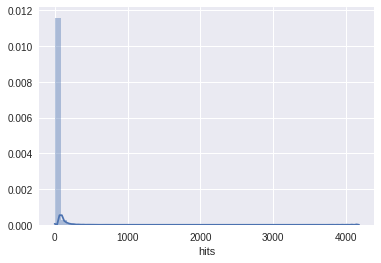

In [10]:
sns.distplot(records_hits_available['hits'])

We can now explore the number of hits per day by using barplot.

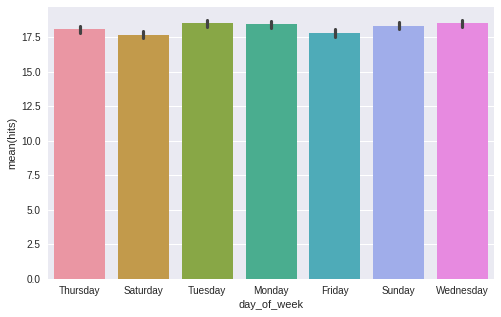

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='hits',data=records_hits_available)

In average, most of the hits occure on Tuesday.

What about the hits per hour of the day?

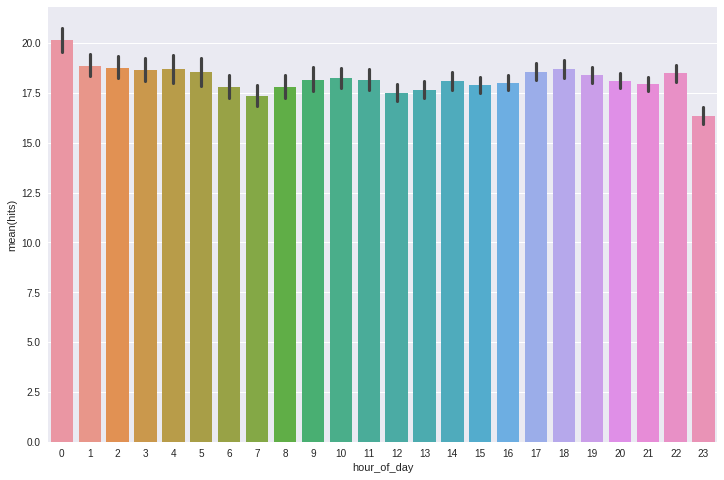

In [23]:
plt.figure(figsize=(12,8))
sns.barplot(x='hour_of_day', y='hits',data=records_hits_available)

We can notice that most of the hits occur on 00h.

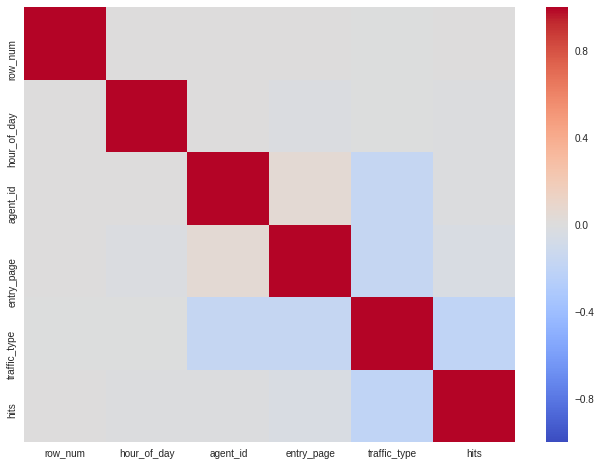

In [26]:
plt.figure(figsize=(11,8))
#seaborn heatmap correlation
sns.heatmap(records_hits_available.corr(),cmap="coolwarm")

## Data transformation

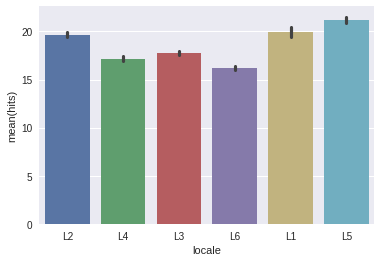

In [20]:
sns.barplot(x='locale', y='hits',data=records_hits_available)

In [36]:
records_hits_available.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,hits
count,619235.000000,619235.000000,619235.000000,619235.000000,619235.000000,619235.000000
mean,494098.480154,13.192517,7.431804,2261.892047,2.713186,18.210079
std,285454.273535,6.766696,3.980112,797.624728,1.882351,39.099699
min,1.000000,0.000000,0.000000,2100.000000,1.000000,1.000000
25%,246820.500000,8.000000,2.000000,2111.000000,1.000000,3.000000
50%,493923.000000,14.000000,9.000000,2113.000000,2.000000,7.000000
75%,741286.500000,19.000000,10.000000,2116.000000,4.000000,19.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000,4174.000000


In [38]:
records['locale'].nunique()

6

In [40]:
records['entry_page'].nunique()

147

In [41]:
records['traffic_type'].nunique()

7

locale, traffic_type are discrete variables

In [42]:
records['agent_id'].nunique()

16

In [43]:
known_hits_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619235 entries, 1 to 988680
Data columns (total 10 columns):
row_num              619235 non-null int64
locale               619235 non-null object
day_of_week          619235 non-null object
hour_of_day          619235 non-null int64
agent_id             619235 non-null int64
entry_page           619235 non-null int64
path_id_set          616082 non-null object
traffic_type         619235 non-null int64
session_durantion    619235 non-null object
hits                 619235 non-null int64
dtypes: int64(6), object(4)
memory usage: 52.0+ MB


Remove Null path_id_set.

In [12]:
records_hits_available.dropna(subset=['path_id_set'],how='any',inplace=True)

In [13]:
records_hits_available.isnull().sum()

row_num              0
locale               0
day_of_week          0
hour_of_day          0
agent_id             0
entry_page           0
path_id_set          0
traffic_type         0
session_durantion    0
hits                 0
dtype: int64

In [52]:
known_hits_records.shape

(616082, 10)

### Frequency of Day of week VS Hour of day

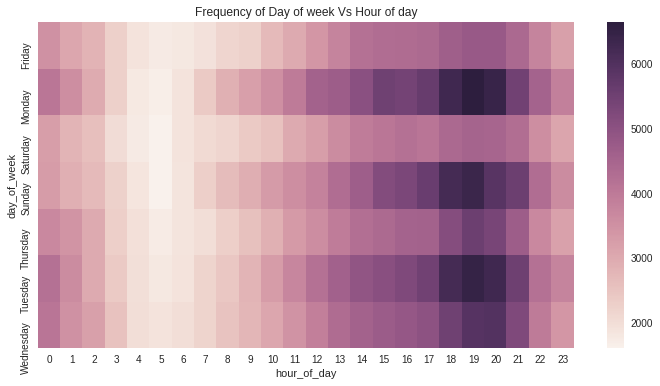

In [24]:
grouped_df  = records_hits_available.groupby(["day_of_week", "hour_of_day"])["row_num"].unique().reset_index()
grouped_df["row_num"] = grouped_df["row_num"].apply(len)

#grouped_df = df.groupby(["Weekday", "hour"])["InvoiceNo"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('day_of_week', 'hour_of_day', 'row_num')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

In [14]:
days = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
records_hits_available['day_of_week'] = records_hits_available['day_of_week'].apply(lambda x: days[x])

In [16]:
records_hits_available.drop('path_id_set',axis=1,inplace=True)

In [17]:
records_hits_available.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,traffic_type,session_durantion,hits
1,988680,L2,4,22,10,2113,2,49,14
2,988679,L4,6,21,2,2100,1,1892,14
3,988678,L3,6,19,8,2113,6,0,1
4,988677,L2,2,6,10,2116,1,2,3
5,988676,L3,1,1,8,2100,1,0,2


In [71]:
known_hits_records['locale'] = known_hits_records.locale.str.replace('L','')

In [72]:
known_hits_records['locale'] = known_hits_records.locale.astype(int)

In [73]:
known_hits_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616082 entries, 1 to 988680
Data columns (total 9 columns):
row_num              616082 non-null int64
locale               616082 non-null int64
day_of_week          616082 non-null int64
hour_of_day          616082 non-null int64
agent_id             616082 non-null int64
entry_page           616082 non-null int64
traffic_type         616082 non-null int64
session_durantion    616082 non-null object
hits                 616082 non-null int64
dtypes: int64(8), object(1)
memory usage: 47.0+ MB


In [27]:
records_hits_available['session_duration'] = records_hits_available.session_duration.replace('\\NaN',value = np.nan)

In [28]:
records_hits_available.dropna(subset=['session_duration'],how='any',inplace=True)

In [30]:
records_hits_available['session_duration'].isnull().sum()

0

In [98]:
known_hits_records.shape

(615668, 9)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection, preprocessing

In [103]:
known_hits_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615668 entries, 1 to 988680
Data columns (total 9 columns):
row_num             615668 non-null int64
locale              615668 non-null int64
day_of_week         615668 non-null int64
hour_of_day         615668 non-null int64
agent_id            615668 non-null int64
entry_page          615668 non-null int64
traffic_type        615668 non-null int64
hits                615668 non-null int64
session_duration    615668 non-null int64
dtypes: int64(9)
memory usage: 47.0 MB


In [104]:
X = np.array(known_hits_records.drop(known_hits_records[['hits']], 1))
y = np.array(known_hits_records['hits'])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

In [105]:
linear_reg = LinearRegression()

In [106]:
linear_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [108]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [109]:
predictions = linear_reg.predict(X_test)

In [110]:
rmse(predictions,y_test)

37.383697515076449

In [111]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, predictions))

In [112]:
rms

37.38369751507645

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_predicted = logreg.predict(X_test)

In [115]:
rms = sqrt(mean_squared_error(y_predicted, y_test))

In [116]:
rms

41.442219418258034

In [117]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [118]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 36.5179


## Spot check algorithms

In [25]:
# Print RMSE score
def get_score(prediction, observations):    
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, observations))))

# Shows scores for train and validation sets    
def train_test(estimator, X_train, X_test, y_train, y_test):
    prediction_train = estimator.predict(X_train)
    # Printing estimator
    print(estimator)
    prediction_test = estimator.predict(X_test)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_test)

In [26]:
records_hits_available.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_duration,hits
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
5,988676,L3,Monday,1,8,2100,0,1,0,2


In [31]:
records_hits_available.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616082 entries, 1 to 988680
Data columns (total 10 columns):
row_num             616082 non-null int64
locale              616082 non-null object
day_of_week         616082 non-null object
hour_of_day         616082 non-null int64
agent_id            616082 non-null int64
entry_page          616082 non-null int64
path_id_set         616082 non-null object
traffic_type        616082 non-null int64
session_duration    616082 non-null object
hits                616082 non-null int64
dtypes: int64(6), object(4)
memory usage: 51.7+ MB


In [36]:
records_hits_available['session_duration'] = records_hits_available.session_duration.replace('\\N',value = np.nan)
records_hits_available.dropna(subset=['session_duration'],how='any',inplace=True)
records_hits_available['session_duration'] = records_hits_available.session_duration.astype(int)

### Linear regression

#### Prepare Data

In [39]:
records_hits_available.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615668 entries, 1 to 988680
Data columns (total 10 columns):
row_num             615668 non-null int64
locale              615668 non-null object
day_of_week         615668 non-null object
hour_of_day         615668 non-null int64
agent_id            615668 non-null int64
entry_page          615668 non-null int64
path_id_set         615668 non-null object
traffic_type        615668 non-null int64
session_duration    615668 non-null int64
hits                615668 non-null int64
dtypes: int64(7), object(3)
memory usage: 51.7+ MB


In [40]:
records_hits_available.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,session_duration,hits
count,615668.000000,615668.000000,615668.000000,615668.000000,615668.000000,615668.000000,615668.000000
mean,494104.458632,13.202320,7.434081,2257.953418,2.709847,494.001288,18.305580
std,285455.620227,6.761316,3.978968,785.306752,1.866371,1917.165817,39.191119
min,1.000000,0.000000,0.000000,2100.000000,1.000000,0.000000,1.000000
25%,246839.750000,8.000000,2.000000,2111.000000,1.000000,4.000000,3.000000
50%,493946.000000,14.000000,9.000000,2113.000000,2.000000,59.000000,7.000000
75%,741299.250000,19.000000,10.000000,2116.000000,4.000000,326.000000,19.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000,86219.000000,4174.000000


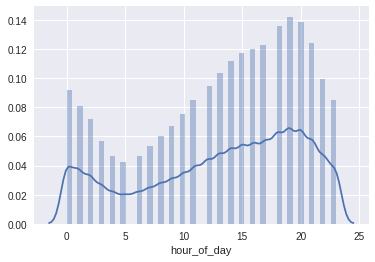

In [53]:
sns.distplot(records_hits_available['hour_of_day'])

The distribution of hour_of_day is not Gaussian and thus need to be transformed.

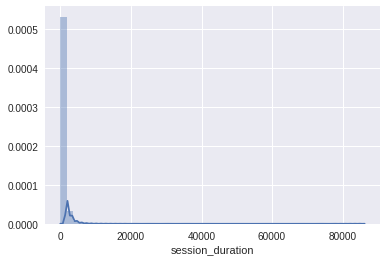

In [50]:
sns.distplot(records_hits_available['session_duration'])

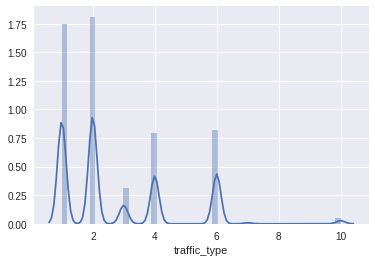

In [51]:
sns.distplot(records_hits_available['traffic_type'])

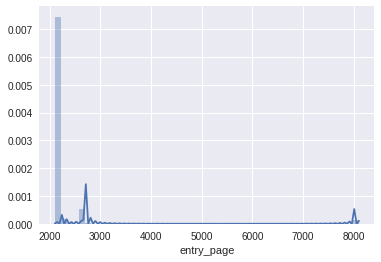

In [44]:
sns.distplot(records_hits_available['entry_page'])

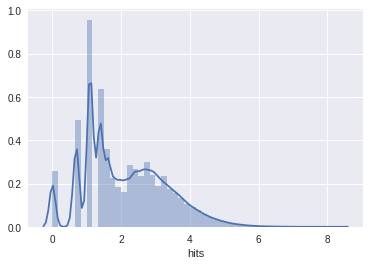

In [47]:
sns.distplot(np.log(records_hits_available['hits']))

In [54]:
records_hits_available['hits'].describe()

count    615668.000000
mean         18.305580
std          39.191119
min           1.000000
25%           3.000000
50%           7.000000
75%          19.000000
max        4174.000000
Name: hits, dtype: float64

In [56]:
records_filtered = records_hits_available[records_hits_available['hits'] < 4000]

In [57]:
records_filtered.shape

(615667, 10)

In [58]:
records_filtered.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,session_duration,hits
count,615667.000000,615667.000000,615667.000000,615667.000000,615667.000000,615667.000000,615667.000000
mean,494105.109369,13.202342,7.434093,2257.952698,2.709850,493.982185,18.298830
std,285455.395397,6.761301,3.978960,785.307186,1.866371,1917.108779,38.831633
min,1.000000,0.000000,0.000000,2100.000000,1.000000,0.000000,1.000000
25%,246841.000000,8.000000,2.000000,2111.000000,1.000000,4.000000,3.000000
50%,493947.000000,14.000000,9.000000,2113.000000,2.000000,59.000000,7.000000
75%,741299.500000,19.000000,10.000000,2116.000000,4.000000,326.000000,19.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000,86219.000000,2603.000000


In [69]:
len(records_filtered[records_filtered['hits']>1000])

62

In [70]:
records_filtered = records_filtered[records_filtered['hits']<=1000]

In [71]:
records_filtered.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,session_duration,hits
count,615605.000000,615605.00000,615605.000000,615605.000000,615605.000000,615605.000000,615605.000000
mean,494103.083653,13.20237,7.434157,2257.964594,2.709976,493.465406,18.156764
std,285458.190411,6.76133,3.978917,785.345270,1.866398,1915.894984,35.921620
min,1.000000,0.00000,0.000000,2100.000000,1.000000,0.000000,1.000000
25%,246838.000000,8.00000,2.000000,2111.000000,1.000000,4.000000,3.000000
50%,493934.000000,14.00000,9.000000,2113.000000,2.000000,59.000000,7.000000
75%,741301.000000,19.00000,10.000000,2116.000000,4.000000,326.000000,19.000000
max,988680.000000,23.00000,15.000000,8101.000000,10.000000,86219.000000,1000.000000


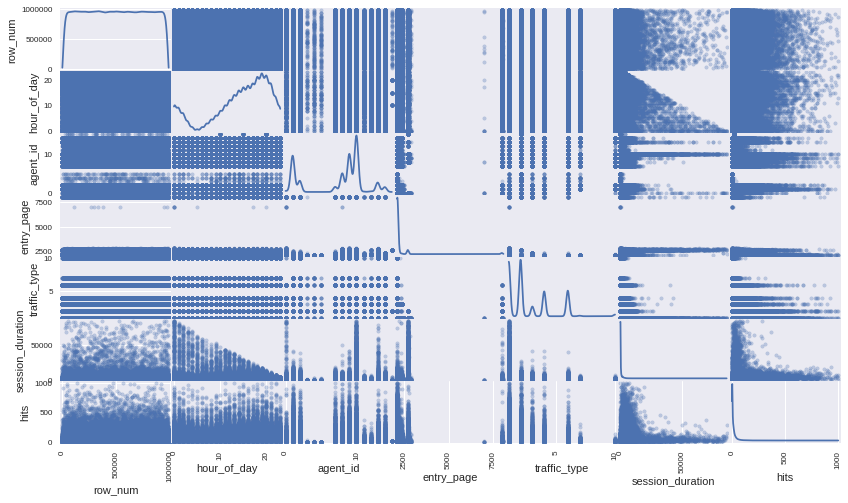

In [72]:
pd.scatter_matrix(records_filtered, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [24]:
records_hits_available['HourGroup'] = records_hits_available['hour_of_day']
records_hits_available.loc[(records_hits_available['HourGroup']>7) & (records_hits_available['HourGroup']<12), 'HourGroup'] = 0
records_hits_available.loc[(records_hits_available['HourGroup']>=12) & (records_hits_available['HourGroup']<=18), 'HourGroup'] = 1
records_hits_available.loc[(records_hits_available['HourGroup']>18) , 'HourGroup'] = 2

In [26]:
records_hits_available['HourGroup'].unique()

array([2, 6, 1, 3, 5, 0, 7, 4])